# The Asymptotics Approximation


The asymptotic approximation described in the paper by Cowan, Cranmer, Gross, Vitells: *Asymptotic formulae for likelihood-based tests of new physics* [[arXiv:1007.1727](https://arxiv.org/abs/1007.1727)] provides an alternative to toy-based calculations of the profile likelihood ratio. 

In Section 3.1 of the paper, it is stated that the approximate distribution of the profile likelihood ratio is only valid in the "large sample limit", e.g. for $n_\text{events} \gg 1$. In other words, the asymptotic formula is only valid for large-enough statistics. This is often why, in experimental particle physics, (slower) toys are computed as a cross-check to ensure that the asymptotic approximation is valid.

Is it really bad in low statistics? This notebook will explore this.

In [1]:
%pylab inline
from IPython.display import Math
import numpy as np
import pyhf

Populating the interactive namespace from numpy and matplotlib


## Computing CLs

In order to compute CLs you need to know the distribution of the value of the test statistic under a certain hypothesis. The test statistic is just a function of the observed data and the assumed model $f(\text{data},\text{model})$.

So the asymptotics paper [[arXiv:1007.1727](https://arxiv.org/abs/1007.1727)] basically gives some analytic formulae on what these distributions of test statistics look like. However, this makes some particular assumptions about the amount of statistics (events) in your model - so this only holds for a subset of cases.

### Generate the model

First, we'll generate a model with low stats. Here, we will have no background events, no observations, but one signal event.

**Note**: background cannot be exactly zero, so we set it to a very small number like $10^{-6}$.

In [24]:
expected_signal = 1
expected_background = 1e-6
background_uncertainty = 1
observed = 0
# generate the spec given above details
model = pyhf.simplemodels.hepdata_like([expected_signal],[expected_background],[background_uncertainty])
print(f'Channels: {model.config.channels}')
print(f'Samples: {model.config.samples}')
print(f'Parameters: {model.config.parameters}')
print(f'Modifiers: {model.config.modifiers}')
data = [observed]+model.config.auxdata

Channels: ['singlechannel']
Samples: ['background', 'signal']
Parameters: ['mu', 'uncorr_bkguncrt']
Modifiers: [('mu', 'normfactor'), ('uncorr_bkguncrt', 'shapesys')]


And, we will calculate $\text{CLs}$ for a few values of $\mu \in [0,5]$.

In [25]:
mu_tests = np.linspace(0, 5, 11)

### Asymptotics

Analytic formula for distribution of test stat

In [26]:
hypo_tests_asymptotics = np.array([
    pyhf.infer.hypotest(
        mu,
        data,
        model,
        return_expected_set=True,
        calctype='asymptotics',
    )
    for mu in mu_tests
])

### Toys

Distribution of test stat approximated using a histogram from fake/sampled data

In [10]:
hypo_tests_toys = np.array([
    pyhf.infer.hypotest(
        mu,
        data,
        model,
        return_expected_set=True,
        calctype='toybased',
    )
    for mu in mu_tests
])

### Plotting the Brazil Curves

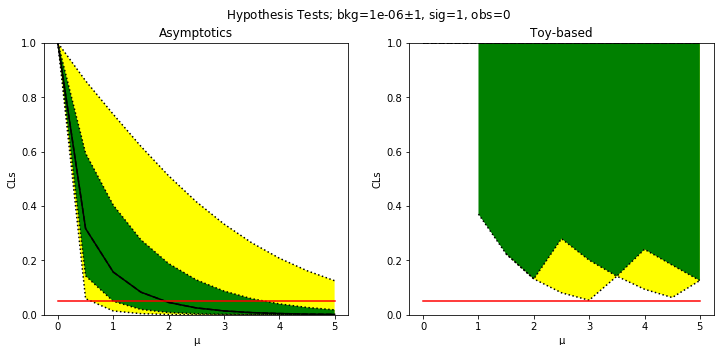

In [16]:
import pyhf.contrib.viz.brazil

# want two columns, but a single row
fig, axes = plt.subplots(nrows=1, ncols=2)
ax0, ax1 = axes.flatten()

fig.set_size_inches(12,5)

fig.suptitle(f"Hypothesis Tests; bkg={expected_background}$\pm${background_uncertainty}, sig={expected_signal}, obs={observed}")
for ax in [ax0, ax1]:
    ax.set_ylabel(u"CLs")
    ax.set_xlabel(u"µ")

ax0.set_title(u"Asymptotics")
ax1.set_title(u"Toy-based")
    
pyhf.contrib.viz.brazil.plot_results(ax0, mu_tests, hypo_tests_asymptotics)
pyhf.contrib.viz.brazil.plot_results(ax1, mu_tests, hypo_tests_toys)

In [17]:
# given the hypo_tests, test_mus - interpolate to identify the intersections in the above plot
def invert_interval(test_mus, hypo_tests, test_size=0.05):
    cls_obs = np.array([test[0] for test in hypo_tests]).flatten()
    cls_exp = [
        np.array([test[1][i] for test in hypo_tests]).flatten() for i in range(5)
    ]
    crossing_test_stats = {"exp": [], "obs": None}
    for cls_exp_sigma in cls_exp:
        crossing_test_stats["exp"].append(
            np.interp(
                test_size, list(reversed(cls_exp_sigma)), list(reversed(test_mus))
            )
        )
    crossing_test_stats["obs"] = np.interp(
        test_size, list(reversed(cls_obs)), list(reversed(test_mus))
    )
    return crossing_test_stats

In [18]:
mu_expected_approx = 2*np.sqrt(expected_background)/expected_signal
mu_observed_approx = 2*np.sqrt(observed)/expected_signal

In [19]:
display(Math(rf'\mu_\text{{expected}} \approx {mu_expected_approx:.2f}'))
display(Math(rf'\mu_\text{{observed}} \approx {mu_observed_approx:.2f}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [23]:
results_asymptotics = invert_interval(mu_tests, hypo_tests_asymptotics)
results_toys = invert_interval(mu_tests, hypo_tests_toys)
display(Math(rf'\text{{Asymptotics}}: \mu_\text{{expected}} = {results_asymptotics["exp"][2]:.2f} \qquad \mu_\text{{observed}} = {results_asymptotics["obs"]:.2f}'))
display(Math(rf'\text{{Toys}}:\qquad\ \ \ \mu_\text{{expected}} = {results_toys["exp"][2]:.2f} \qquad \mu_\text{{observed}} = {results_toys["obs"]:.2f}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>